This notebook explores: 
* The amount of missing data (due to errors, or information that wasn't captured in older versions)
* The number of tokens used for prompts and cost for each tool 

In [43]:
from costing import costing
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.set_option("display.precision", 4)
pd.set_option('display.max_columns', None)

plt.style.use('ggplot')

### Load data

In [44]:
# csv ending in _old is the original data
# others are extracted using the concurrent script

dataset = pd.read_csv("../dataset.csv")
requests = pd.read_csv("../requests.csv")
tools = pd.read_csv("../tools.csv")

# drop duplicates by request_id
dataset = dataset.drop_duplicates(subset=['request_id'])
requests = requests.drop_duplicates(subset=['request_id'])
tools = tools.drop_duplicates(subset=['request_id'])

### Error calls

In [45]:
tools['request_block_bucket'] = tools['request_block'].apply(lambda x: x // 100_000)

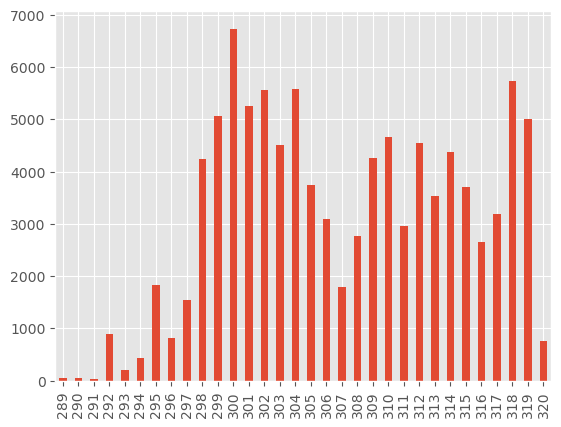

In [46]:
tools['request_block_bucket'].value_counts().sort_index().plot(kind='bar')

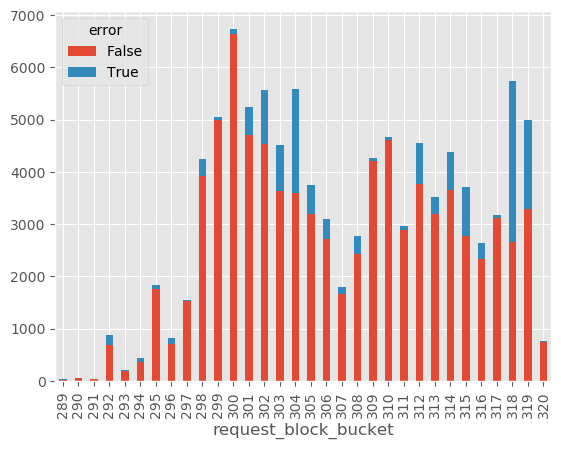

In [47]:
tools.groupby(['request_block_bucket', 'error']).size().unstack().plot(kind='bar', stacked=True)

In [48]:
# number of requests per bucket to each tool
tools.groupby(['tool', 'request_block_bucket']).count()['request_id'].unstack().fillna(0).loc[:, 300:]

request_block_bucket,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320
tool,,,,,,,,,,,,,,,,,,,,,
claude-prediction-offline,0.0,261.0,865.0,694.0,1039.0,793.0,732.0,144.0,1.0,3.0,2.0,18.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0
claude-prediction-online,0.0,456.0,936.0,699.0,2403.0,465.0,170.0,82.0,0.0,2.0,4.0,39.0,226.0,248.0,698.0,905.0,250.0,296.0,291.0,306.0,59.0
normal-sme-generator,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
openai,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
openai-gpt-3.5-turbo-instruct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3003.0,1667.0,3.0
prediction-offline,10.0,583.0,927.0,693.0,383.0,590.0,271.0,48.0,0.0,0.0,9.0,25.0,0.0,1.0,0.0,8.0,0.0,1.0,0.0,0.0,0.0
prediction-offline-sme,0.0,217.0,924.0,825.0,423.0,550.0,789.0,429.0,0.0,0.0,24.0,21.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
prediction-online,6658.0,3386.0,925.0,753.0,924.0,939.0,702.0,588.0,1459.0,2202.0,2348.0,1400.0,413.0,44.0,26.0,73.0,52.0,6.0,1.0,0.0,0.0
prediction-online-sme,44.0,349.0,992.0,847.0,414.0,412.0,425.0,260.0,1310.0,2051.0,2279.0,1458.0,3273.0,3105.0,3638.0,2643.0,2298.0,2873.0,2446.0,3026.0,705.0


In [50]:
# number of non-error requests per bucket to each tool
tools[tools['error'] == False].groupby(['tool', 'request_block_bucket']).count()['request_id'].unstack().fillna(0).loc[:, 300:]

request_block_bucket,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320
tool,,,,,,,,,,,,,,,,,,,,,
claude-prediction-offline,0.0,176.0,636.0,423.0,694.0,630.0,564.0,107.0,1.0,3.0,1.0,2.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0
claude-prediction-online,0.0,112.0,170.0,138.0,770.0,201.0,75.0,39.0,0.0,0.0,1.0,3.0,15.0,7.0,2.0,0.0,15.0,248.0,221.0,274.0,51.0
prediction-offline,10.0,578.0,922.0,687.0,383.0,558.0,268.0,48.0,0.0,0.0,9.0,25.0,0.0,1.0,0.0,8.0,0.0,1.0,0.0,0.0,0.0
prediction-offline-sme,0.0,215.0,917.0,817.0,422.0,516.0,727.0,427.0,0.0,0.0,24.0,21.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
prediction-online,6579.0,3292.0,915.0,743.0,921.0,897.0,679.0,572.0,1281.0,2180.0,2322.0,1390.0,410.0,44.0,26.0,73.0,50.0,6.0,1.0,0.0,0.0
prediction-online-sme,42.0,334.0,976.0,830.0,412.0,394.0,406.0,255.0,1152.0,2030.0,2258.0,1445.0,3242.0,3099.0,3622.0,2637.0,2252.0,2863.0,2438.0,3009.0,703.0
prediction-online-summarized-info,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,105.0,44.0,8.0,24.0,20.0,1.0,1.0,0.0,0.0
prediction-sentence-embedding-bold,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
prediction-sentence-embedding-conservative,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# number of error requests per bucket to each tool
tools[tools['error'] == True].groupby(['tool', 'request_block_bucket']).count()['request_id'].unstack().fillna(0).loc[:, 300:]

request_block_bucket,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320
tool,,,,,,,,,,,,,,,,,,,,,
claude-prediction-offline,0.0,85.0,229.0,271.0,345.0,163.0,168.0,37.0,0.0,0.0,1.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
claude-prediction-online,0.0,344.0,766.0,561.0,1633.0,264.0,95.0,43.0,0.0,2.0,3.0,36.0,211.0,241.0,696.0,905.0,235.0,48.0,70.0,32.0,8.0
normal-sme-generator,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
openai,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
openai-gpt-3.5-turbo-instruct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3003.0,1667.0,3.0
prediction-offline,0.0,5.0,5.0,6.0,0.0,32.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
prediction-offline-sme,0.0,2.0,7.0,8.0,1.0,34.0,62.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
prediction-online,79.0,94.0,10.0,10.0,3.0,42.0,23.0,16.0,178.0,22.0,26.0,10.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
prediction-online-sme,2.0,15.0,16.0,17.0,2.0,18.0,19.0,5.0,158.0,21.0,21.0,13.0,31.0,6.0,16.0,6.0,46.0,10.0,8.0,17.0,2.0


In [53]:
err = tools.groupby(['tool', 'request_block_bucket', 'error']).count()['request_id'].unstack().unstack().fillna(0)
(err[False] / (err[False] + err[True])).fillna(0).loc[:, 300:]

request_block_bucket,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320
tool,,,,,,,,,,,,,,,,,,,,,
claude-prediction-offline,0.0000,0.6743,0.7353,0.6095,0.6679,0.7945,0.7705,0.7431,1.0000,1.0000,0.5000,0.1111,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
claude-prediction-online,0.0000,0.2456,0.1816,0.1974,0.3204,0.4323,0.4412,0.4756,0.0000,0.0000,0.2500,0.0769,0.0664,0.0282,0.0029,0.0000,0.0600,0.8378,0.7595,0.8954,0.8644
normal-sme-generator,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
openai,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
openai-gpt-3.5-turbo-instruct,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
prediction-offline,1.0000,0.9914,0.9946,0.9913,1.0000,0.9458,0.9889,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000
prediction-offline-sme,0.0000,0.9908,0.9924,0.9903,0.9976,0.9382,0.9214,0.9953,0.0000,0.0000,1.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
prediction-online,0.9881,0.9722,0.9892,0.9867,0.9968,0.9553,0.9672,0.9728,0.8780,0.9900,0.9889,0.9929,0.9927,1.0000,1.0000,1.0000,0.9615,1.0000,1.0000,0.0000,0.0000
prediction-online-sme,0.9545,0.9570,0.9839,0.9799,0.9952,0.9563,0.9553,0.9808,0.8794,0.9898,0.9908,0.9911,0.9905,0.9981,0.9956,0.9977,0.9800,0.9965,0.9967,0.9944,0.9972


In [58]:
tools[tools['tool'].str.contains('instruct')].groupby(['request_block_bucket', 'error_message']).count()['request_id'].unstack()

error_message,Invalid response from tool,Response parsing error
request_block_bucket,,
318,1.0,3002.0
319,NaN,1667.0
320,NaN,3.0


Learnings
- most of the request are going to prediction-online-sme
- most of the errors recently came from openai-gpt-3.5-turbo-instruct	
- specifically, it was parsing error (would function calling help? or instruct model do not follow instructions that well?)

### Costing

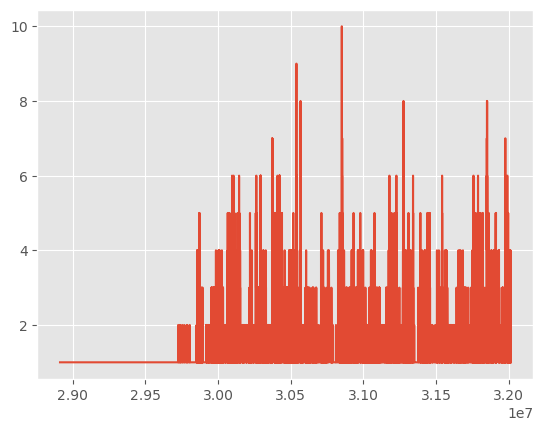

In [59]:
tools['deliver_block'].value_counts().sort_index().plot()

There is less data on new `tools` because `old_mech` didnt save the full prompt

In [66]:
# add full_prompt to dataset
include_tools = [
    'prediction-offline',
    'prediction-online',
    'prediction-online-summarized-info',
    'prediction-offline-sme',
    'prediction-online-sme',
    'claude-prediction-online',
    'claude-prediction-offline'
]

tools = tools[tools.tool.isin(include_tools)]

# Select only non na prompt_response
tools = tools[tools.prompt_response.notna()]

Below we calculate the number of words in the request prompts and response prompts. 

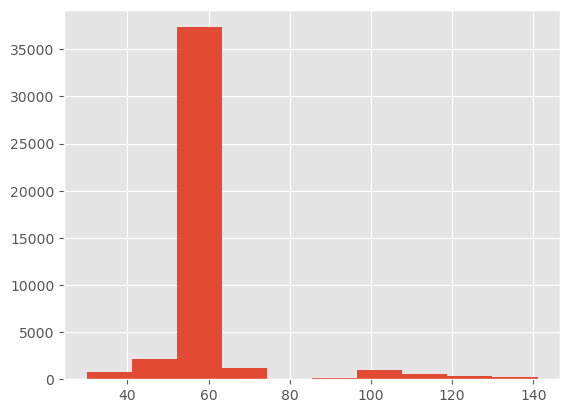

In [67]:
# prompt_request is the from the prompt from trader to mech (tool)
tools['prompt_request'].apply(lambda x: len(x.split(' '))).hist()

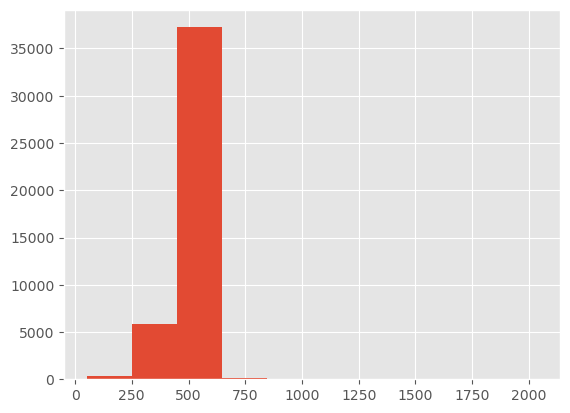

In [68]:
# prompt_response is the full prompt used by the mech (tool)
tools['prompt_response'].apply(lambda x: len(x.split(' '))).hist()

Below, we calculate the number of tokens in the request prompts and response prompts.  

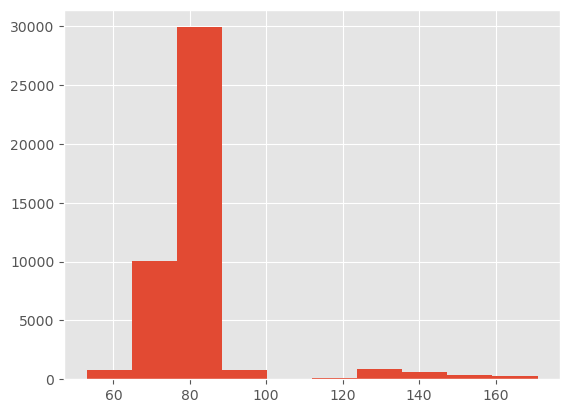

In [69]:
tools['prompt_request_token'] = tools['prompt_request'].apply(lambda x: costing.TokenCounter.count_tokens(x, model='gpt-3.5-turbo'))
tools['prompt_request'].apply(lambda x: costing.TokenCounter.count_tokens(x, model='gpt-3.5-turbo')).hist()

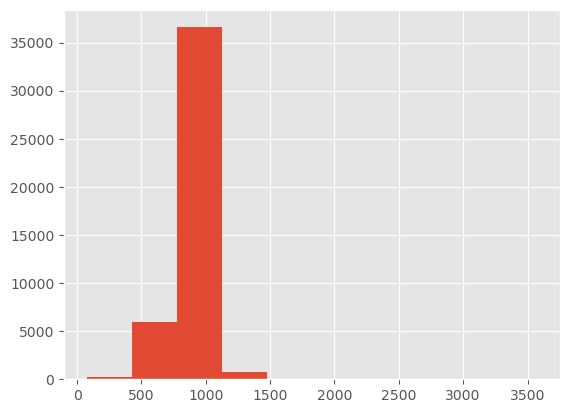

In [71]:
tools['prompt_response_token'] = tools['prompt_response'].apply(lambda x: costing.TokenCounter.count_tokens(x, model='gpt-3.5-turbo'))
tools['prompt_response_token'].hist()

Below, we show the number of response prompt tokens used for each tool. 

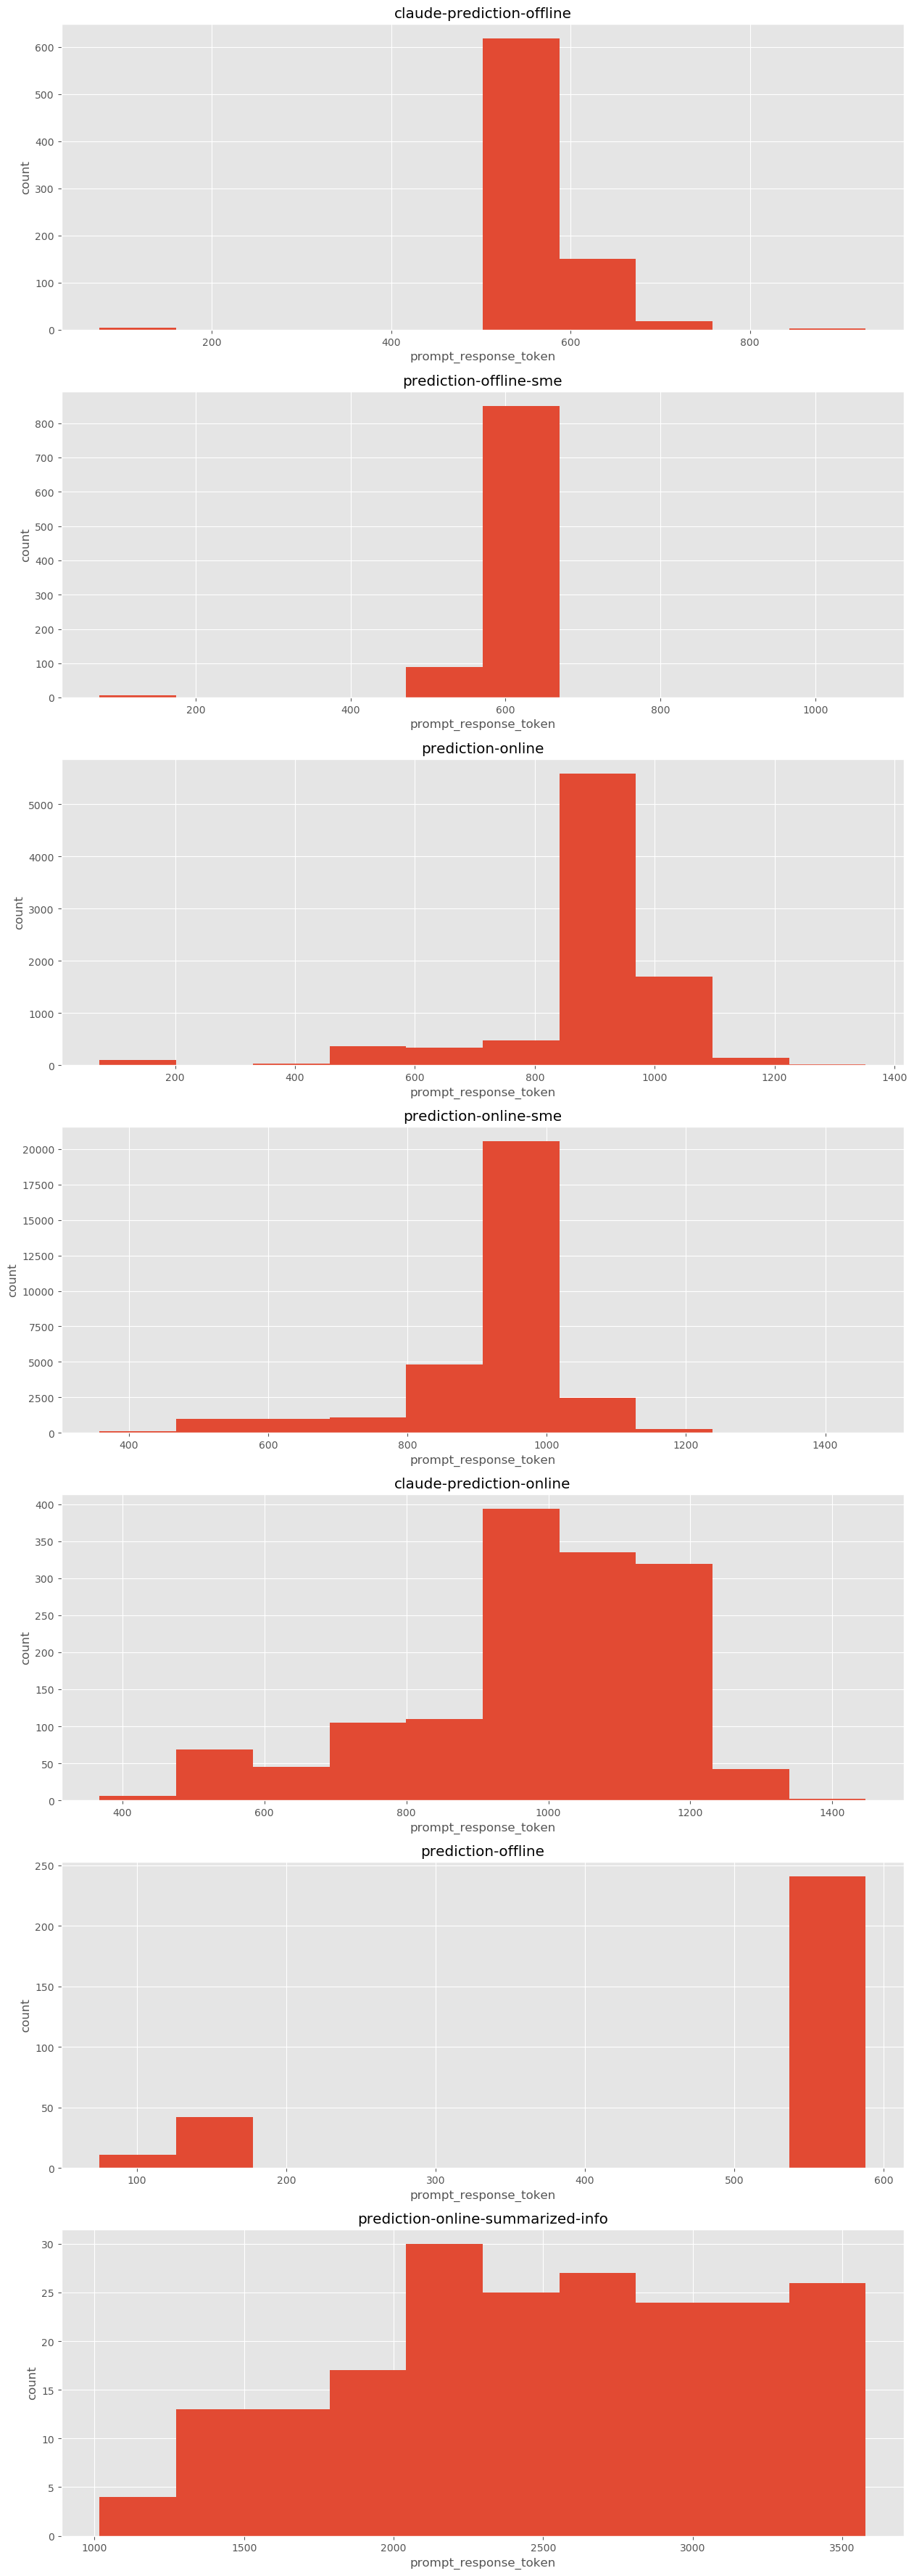

In [72]:
fig, axes = plt.subplots(7, 1, figsize=(15, 45))

for i, tool in enumerate(tools['tool'].unique()):
    tools[tools['tool'] == tool]['prompt_response_token'].hist(ax=axes[i])
    axes[i].set_title(tool)
    axes[i].set_xlabel('prompt_response_token')
    axes[i].set_ylabel('count')

Below is the mean prompt response tokens for each tool, sorted by most tokens. 

In [73]:
tools.groupby('tool')['prompt_response_token'].mean().sort_values(ascending=False)

tool
prediction-online-summarized-info    2521.2118
claude-prediction-online              985.9727
prediction-online-sme                 916.9168
prediction-online                     897.0768
claude-prediction-offline             589.1633
prediction-offline-sme                583.6860
prediction-offline                    492.3741
Name: prompt_response_token, dtype: float64

In [74]:
for data in tqdm(tools.iterrows(), total=len(tools), desc='Counting costs'):
    tool = data[1].tool
    prompt = data[1].prompt_response
    response = None
    counter = costing.CostCounter(tool=tool, prediciton_prompt=prompt, final_response=response)
    cost = counter.run()
    tools.loc[data[0], 'cost'] = cost
    tools.loc[data[0], 'input_tokens'] = counter.total_input_tokens
    tools.loc[data[0], 'output_tokens'] = counter.total_output_tokens

Counting costs: 100%|██████████| 43692/43692 [01:49<00:00, 399.14it/s]


The below tables show more about the distribution about the overall cost for each tool.

In [75]:
tools.groupby('tool').cost.aggregate([
    'min', 'max', 'mean', 'median',
    lambda x: np.percentile(x, 75), 
    lambda x: np.percentile(x, 90)
]).rename(columns={
    '<lambda_0>': '75th percentile',
    '<lambda_1>': '90th percentile'
}).sort_values(by='90th percentile', ascending=False)

,min,max,mean,median,75th percentile,90th percentile
tool,,,,,,
claude-prediction-online,0.0389,0.0564,0.0492,0.0495,0.0515,0.0521
prediction-online-summarized-info,0.0278,0.0329,0.0308,0.0308,0.0318,0.0324
prediction-online-sme,0.0274,0.0307,0.0291,0.0291,0.0292,0.0294
prediction-online,0.0259,0.0284,0.0275,0.0276,0.0276,0.0277
claude-prediction-offline,0.0030,0.0103,0.0075,0.0074,0.0074,0.0077
prediction-offline-sme,0.0010,0.0029,0.0020,0.0020,0.0020,0.0021
prediction-offline,0.0003,0.0008,0.0007,0.0008,0.0008,0.0008


In [76]:
tools.groupby('tool').input_tokens.aggregate([
    'min', 'max', 'mean', 'median',
    lambda x: np.percentile(x, 75), 
    lambda x: np.percentile(x, 90)
]).rename(columns={
    '<lambda_0>': '75th percentile',
    '<lambda_1>': '90th percentile'
}).sort_values(by='90th percentile', ascending=False)

,min,max,mean,median,75th percentile,90th percentile
tool,,,,,,
prediction-online-summarized-info,2353.0,7475.0,5361.4236,5401.0,6436.0,7007.0
prediction-online-sme,1802.0,5102.0,3478.7504,3539.0,3638.0,3764.0
claude-prediction-online,1143.0,3331.0,2422.9727,2468.0,2711.0,2793.0
prediction-online,468.0,3023.0,2113.1649,2179.0,2243.0,2323.0
prediction-offline-sme,562.0,2539.0,1576.3783,1563.0,1571.0,1685.4
claude-prediction-offline,76.0,987.0,632.3304,624.0,629.0,664.0
prediction-offline,75.0,588.0,492.3741,572.0,577.0,581.0


In [77]:
tools.groupby('tool').output_tokens.aggregate([
    'min', 'max', 'mean', 'median',
    lambda x: np.percentile(x, 75), 
    lambda x: np.percentile(x, 90)
]).rename(columns={
    '<lambda_0>': '75th percentile',
    '<lambda_1>': '90th percentile'
}).sort_values(by='90th percentile', ascending=False)

,min,max,mean,median,75th percentile,90th percentile
tool,,,,,,
prediction-online-sme,300.0,300.0,300.0,300.0,300.0,300.0
claude-prediction-online,200.0,200.0,200.0,200.0,200.0,200.0
prediction-offline-sme,200.0,200.0,200.0,200.0,200.0,200.0
prediction-online,200.0,200.0,200.0,200.0,200.0,200.0
prediction-online-summarized-info,200.0,200.0,200.0,200.0,200.0,200.0
claude-prediction-offline,100.0,100.0,100.0,100.0,100.0,100.0
prediction-offline,100.0,100.0,100.0,100.0,100.0,100.0
